In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm
from libs.mmd import MMD

In [2]:
import zuko
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform

In [3]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_ordered_data", "W_ordered_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_ordered_data", "W_ordered_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=600000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=100000, device="cuda")

# Create DataLoader
batch_size = 2048
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=True)

In [4]:
jets, lepton, met, full_mask, nu, W = dataset_train[0:10000]

In [5]:
met

tensor([[[ 0.6943, -0.6469]],

        [[-3.6579, -0.8850]],

        [[ 1.4055, -0.6821]],

        ...,

        [[-0.1278, -0.5388]],

        [[ 0.0933, -0.2504]],

        [[-0.8517,  1.2114]]], device='cuda:0')

Text(0.5, 0, 'nu phi normalized')

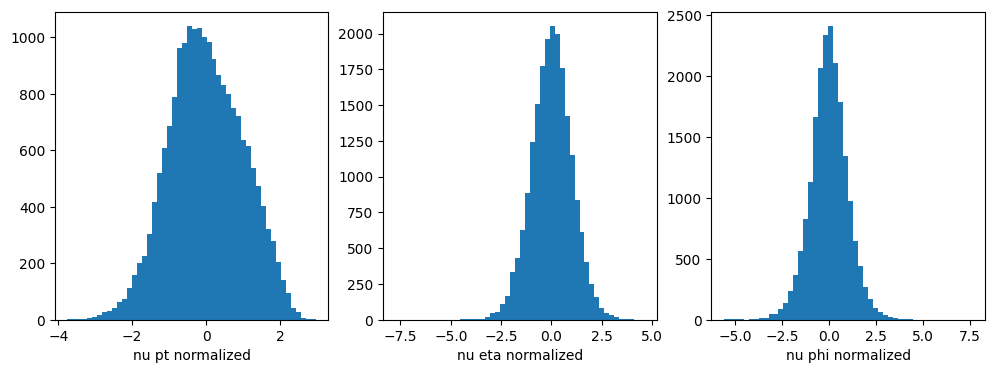

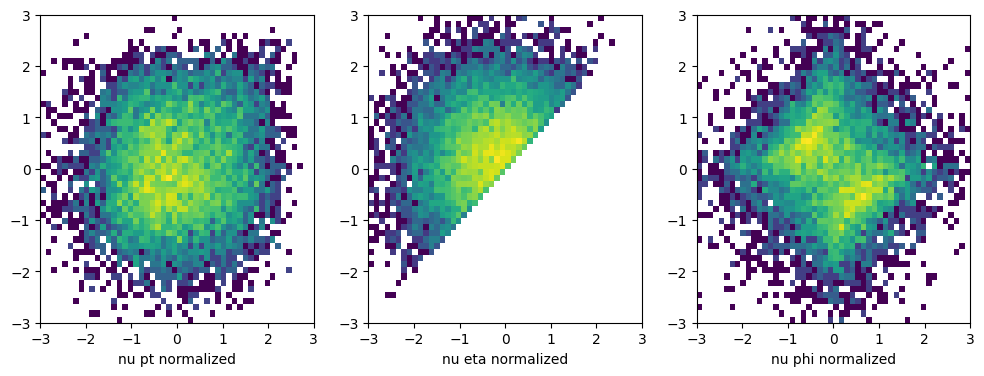

In [6]:
f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(nu.cpu().numpy()[:,:,0].flatten(), bins=50);
axs[0].set_xlabel("nu pt normalized")
axs[1].hist(nu.cpu().numpy()[:,:,1].flatten(), bins=50);
axs[1].set_xlabel("nu eta normalized")
axs[2].hist(nu.cpu().numpy()[:,:,2].flatten(), bins=50);
axs[2].set_xlabel("nu phi normalized")

f, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist2d(nu.cpu().numpy()[:,0,0].flatten(),
            nu.cpu().numpy()[:,1,0].flatten(), bins=50, range=((-3,3),(-3,3)), norm=LogNorm());
axs[0].set_xlabel("nu pt normalized")
axs[1].hist2d(nu.cpu().numpy()[:,0,1].flatten(),
            nu.cpu().numpy()[:,1,1].flatten(), bins=50,  range=((-3,3),(-3,3)),norm=LogNorm());
axs[1].set_xlabel("nu eta normalized")
axs[2].hist2d(nu.cpu().numpy()[:,0,2].flatten(),
            nu.cpu().numpy()[:,1,2].flatten(), bins=50,  range=((-3,3),(-3,3)), norm=LogNorm());
axs[2].set_xlabel("nu phi normalized")

# Transformer Encoder for Normalizing Flow context

In [7]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer
from libs.transformer_models import get_obj_type_tensor, count_parameters

class WWEncoder(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=16,
                 output_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        
        self.transformer_enclayer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.transformer_enclayer, num_layers=num_encoder_layers, enable_nested_tensor=True)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )

        # Building the accumulation net for the output of the encoder
        _layers = [nn.Linear(d_model, output_net[0]), nn.SELU()]
        for i in range(len(output_net)-1):
            _layers.append(nn.Linear(output_net[i], output_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(output_net[-1], 1))
        _layers.append(nn.Sigmoid()) # to have a number between [0,1]
        self.output_network = nn.Sequential(*_layers)
        self.proj_out = nn.Linear(d_model, output_dim)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        # the src_key_padding_mask needs to have True where the tokens are padded. 
        # Our full mask has 1 where the tokens are preset
        pad_mask = full_mask == 0
        out_transf = self.transformer_encoder(src=emb, src_key_padding_mask=pad_mask)
        score = self.output_network(out_transf)
        #Now using the score to accumulate the output
        # we need to mask the transformer encoder token that are padded
        out = torch.sum((out_transf * score * full_mask.unsqueeze(2)), axis=1)
        # Final projection
        out = self.proj_out(out)
        return out

In [8]:
# Example usage
d_model = 64
output_dim = 16
nhead = 4
num_encoder_layers = 2

model = WWEncoder(d_model, nhead, num_encoder_layers,
                   output_dim = output_dim,
                   output_net=[16])
model.to("cuda")
print(f"Model parameters: {count_parameters(model)}")

Model parameters: 251940


In [9]:
out = model(jets, lepton, met, full_mask)
print(out)

tensor([[ 0.7192,  0.9751, -0.8131,  ..., -2.5037, -0.6386, -0.0722],
        [ 1.2186, -1.0635, -0.8728,  ..., -3.0369, -1.3480, -0.8228],
        [ 0.4431,  0.0831, -1.2332,  ..., -2.5887, -1.0655,  0.3198],
        ...,
        [ 2.5769, -1.6655, -1.5795,  ..., -3.2396, -0.8243, -0.4849],
        [ 1.1711, -0.6374, -0.5903,  ..., -1.8119, -1.2672,  0.1676],
        [ 0.4116, -0.5083, -0.7307,  ..., -1.7367,  0.2941,  0.1736]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


We have obtained a dimension vector to be used as a conditioning input for the flow. 

Flow documentation: https://zuko.readthedocs.io/stable/api/zuko.flows.autoregressive.html#zuko.flows.autoregressive.MAF

In [10]:
flow = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
        UnconditionalTransform(RotationTransform, torch.randn(6, 6)),
        MaskedAutoregressiveTransform(features=6, context=16, hidden_features=(64, 64), passes=2),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(6),
        torch.ones(6),
        buffer=True,
    ),
)
flow.to("cuda")

Flow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
    (1): UnconditionalTransform(RotationTransform())
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 0, 0, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=22, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=12, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([6]), scale: torch.Size([6

In [11]:
out.shape

torch.Size([10000, 16])

In [12]:
torch.reshape(nu, [nu.shape[0], 6])

tensor([[ 1.0956, -0.5457, -0.7246, -0.7780, -0.3499, -0.0498],
        [-0.5655, -0.7211, -1.5418, -0.9857,  1.0774,  0.1102],
        [ 1.7940, -1.2574, -0.7500, -0.3377,  0.8539,  1.0961],
        ...,
        [ 0.5429,  1.1126, -0.7615, -1.1515,  1.4716,  0.1240],
        [ 0.0134,  0.0472, -0.3597, -0.3806,  0.1763, -0.1090],
        [-1.8557, -1.7388, -0.1459, -0.3827, -1.0089,  1.1335]],
       device='cuda:0')

In [13]:
log_prob = flow(out).log_prob(torch.reshape(nu, [nu.shape[0], 6]))

Text(0.5, 0, 'log(prob) of neutrinos')

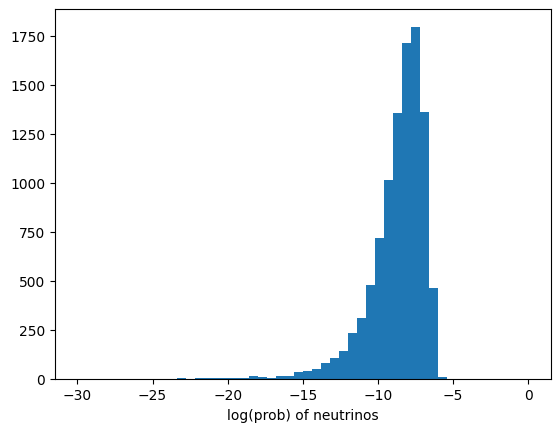

In [14]:
plt.hist(log_prob.cpu().detach().numpy(), bins=50, range=(-30, 0));
plt.xlabel("log(prob) of neutrinos")

## Full model

In [15]:
from torch import nn
from torch.nn import TransformerEncoder,TransformerEncoderLayer
from libs.transformer_models import get_obj_type_tensor, count_parameters

class NeutrinosFlow(nn.Module):
    
    def __init__(self, 
                 flow_nlayers=4, 
                 flow_hidden_net=(64,64),
                 flow_coupling=True,
                 d_model=128, 
                 nhead=8, 
                 num_encoder_layers=2, 
                 dim_feedforward=512,
                 context_dim=16,
                 context_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()

        self.encoder = WWEncoder(d_model=d_model,
                                 nhead=nhead, 
                                 num_encoder_layers=num_encoder_layers, 
                                 dim_feedforward=num_encoder_layers,
                                 output_dim=context_dim,
                                 output_net=context_net,
                                 jet_features = jet_features,
                                 let_features = let_features, 
                                 met_features = met_features,
                                 max_njets= max_njets)

        self.DNN = nn.Sequential(
            nn.Linear(context_dim, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 3*2), # 4vector (but no mass) for two neutrinos
        )
        
        flow_transf_layers = []
        for i in range(flow_nlayers-1):
            flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
            # Let's add a rotation of the features
            flow_transf_layers.append(UnconditionalTransform(RotationTransform, torch.randn(6, 6)))
        # adding last transformation
        flow_transf_layers.append(MaskedAutoregressiveTransform(features=6, 
                                                                    context=context_dim, 
                                                                    hidden_features=flow_hidden_net, 
                                                                    passes=2 if flow_coupling else None))
  
        self.flow = Flow(
                transform=flow_transf_layers,
                base=UnconditionalDistribution(
                    DiagNormal,
                    torch.zeros(6),
                    torch.ones(6),
                    buffer=True,
                ),
            )

    def forward(self, jets, leptons, met, full_mask):
        conditioning_vector = self.encoder(jets, leptons, met, full_mask)
        neutrino_momenta = self.DNN(conditioning_vector)
        out_flow = self.flow(conditioning_vector)
        # Our model returns a flow model with the correct conditioning
        return (neutrino_momenta, out_flow)

In [16]:
# criterion_regression = nn.MSELoss(reduction='none')
# criterion_regression =  MMD
criterion_regression = lambda y, y_true: (nn.MSELoss(reduction='none')(y, y_true).mean(), MMD(y, y_true, kernel='multiscale', device='cuda', dtype=torch.float32).mean())

def train_regression(model, device, loader, val_loader,  optimizer, epochs):
    for param in model.encoder.parameters():
        param.requires_grad = True
    for param in model.DNN.parameters():
        param.requires_grad = True
    for param in model.flow.parameters():
        param.requires_grad = False
    
    for epoch in range(epochs):
        
        model.train()
        
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            optimizer.zero_grad()
            neutrino_momenta, _ =  model(jets,lepton,met, full_mask)
            loss_regression = criterion_regression(neutrino_momenta, torch.reshape(nu, [nu.shape[0], 6]))
            loss_regression_value = loss_regression[0] + 10*loss_regression[1]
            #log_prob = out_flow.log_prob(torch.reshape(nu, [nu.shape[0], 6]))
            #print(-log_prob.mean().item(), loss_regression.mean().item())
            loss = loss_regression_value
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, {loss_regression[0].item()}, {loss_regression[1].item()} ")
                
            loss.backward()
            
            optimizer.step()
            
    
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
       
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                
                #flow_conditioned_val = model(jets_val,lepton_val, met_val, full_mask_val)
                neutrino_momenta, _ =  model(jets_val,lepton_val,met_val, full_mask_val)
                #log_prob_val = flow_conditioned_val.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))

                loss_regression = criterion_regression(neutrino_momenta, torch.reshape(nu_val, [nu_val.shape[0], 6]))
                loss_regression_value = loss_regression[0] + 10* loss_regression[1]
                #log_prob = out_flow.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))
                val_loss =  loss_regression_value
                # val_loss = - log_prob_val.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

           
        print(f"End of epoch {epoch}")
    return model

## Maximum likelihood training

In [17]:

def train_flow(model, device, loader, val_loader,  optimizer, epochs):
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.DNN.parameters():
        param.requires_grad = False
    for param in model.flow.parameters():
        param.requires_grad = True
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            optimizer.zero_grad()
            _, out_flow =  model(jets,lepton,met, full_mask)
            
            log_prob = out_flow.log_prob(torch.reshape(nu, [nu.shape[0], 6]))
            
            loss = -log_prob.mean()
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}")
                
            loss.backward()
            
            optimizer.step()
            
    
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
       
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                
                #flow_conditioned_val = model(jets_val,lepton_val, met_val, full_mask_val)
                _, out_flow =  model(jets_val,lepton_val,met_val, full_mask_val)
                #log_prob_val = flow_conditioned_val.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))

               
                log_prob = out_flow.log_prob(torch.reshape(nu_val, [nu_val.shape[0], 6]))
                val_loss = -log_prob.mean() 
                # val_loss = - log_prob_val.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

           
        print(f"End of epoch {epoch}")
    return model

In [18]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
flow_nlayers= 2
flow_hidden_net=(64,64)
context_net=[32,32]
flow_coupling=False
learning_rate = 1e-3
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeutrinosFlow(d_model = d_model,
                    nhead = nhead,
                    num_encoder_layers = num_encoder_layers,
                    flow_nlayers=flow_nlayers ,
                    flow_hidden_net=flow_hidden_net,
                    flow_coupling=flow_coupling,
                     context_net=context_net)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"Model parameters: {count_parameters(model)}")

Model parameters: 108634


In [19]:
trained_regr = train_regression(model, device, dataloader_train, dataloader_val, optimizer, num_epochs)

epoch 0, step 0, Loss: 31.3568, 0.9885918498039246, 3.03682541847229 
epoch 0, step 100, Loss: 1.4561, 1.148468017578125, 0.03076682612299919 
epoch 0, step 200, Loss: 1.1898, 1.0716267824172974, 0.011815238744020462 
epoch 0, Validation Loss: 1.0599
End of epoch 0
epoch 1, step 0, Loss: 1.1247, 1.0053741931915283, 0.011928606778383255 
epoch 1, step 100, Loss: 1.0403, 0.924758791923523, 0.011553849093616009 
epoch 1, step 200, Loss: 0.9866, 0.8902217149734497, 0.00964188203215599 
epoch 1, Validation Loss: 0.9874
End of epoch 1
epoch 2, step 0, Loss: 0.9912, 0.8756064772605896, 0.01155975740402937 
epoch 2, step 100, Loss: 0.9734, 0.8765522837638855, 0.009682511910796165 
epoch 2, step 200, Loss: 0.9584, 0.8726325035095215, 0.00857520755380392 
epoch 2, Validation Loss: 0.9300
End of epoch 2
epoch 3, step 0, Loss: 0.9970, 0.872931957244873, 0.01240747794508934 
epoch 3, step 100, Loss: 0.9187, 0.8199561834335327, 0.009876268915832043 
epoch 3, step 200, Loss: 0.8898, 0.798410594463348

In [20]:
torch.save(model.state_dict(), "models/models_nuflow_coupling_regression_only.pt")

In [21]:
def plot_samples(nu_sampl, nu_true):
    f1 , axs = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            f = plt
            axs[i][j].hist2d(nu_true[:,i, j],nu_sampl[:,i, j],
              bins=60, 
            norm=LogNorm())
            axs[i][j].set_xlim(-4,4)
            axs[i][j].set_ylim(-4,4)
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

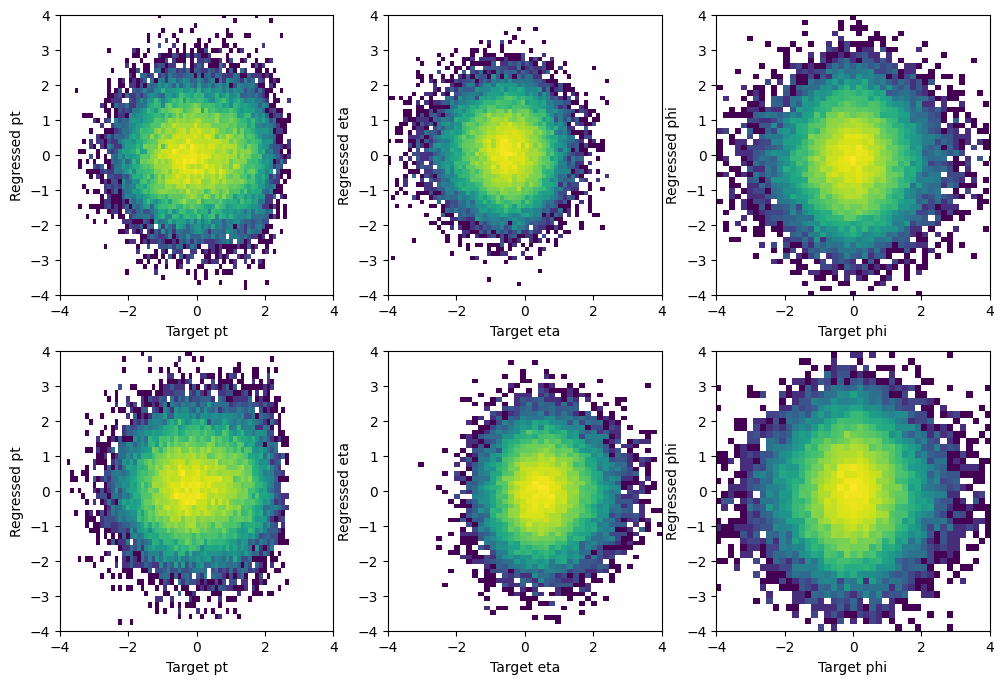

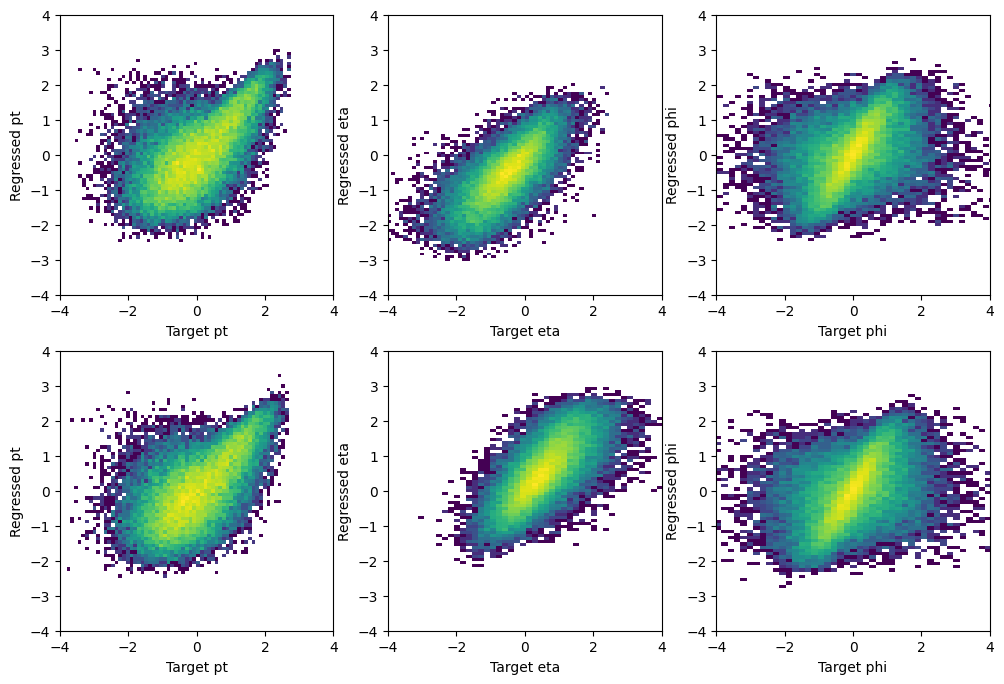

In [22]:
#def validate_flow(model, dataset_val):
Nsamples = 30000
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=Nsamples, device="cuda")

samples_all = torch.zeros(1, Nsamples,  6)
neutrino_m_all = torch.zeros(1, Nsamples,  6)
with torch.no_grad():
    for i in range(Nsamples // 100):
        jets, lepton, met, full_mask, nu, W = dataset_val[i*100:(i+1)*100]
        neutrino_momenta, samples = model(jets,lepton,met, full_mask)
        samples = samples.rsample((1,))
        samples_all[0:, i*100:(i+1)*100] = samples.cpu()
        neutrino_m_all[0:, i*100:(i+1)*100] = neutrino_momenta.cpu()

nu_sampl = torch.reshape(samples_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_sampl_dnn = torch.reshape(neutrino_m_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_true = dataset_val[0:Nsamples][4]
plot_samples(nu_sampl, nu_true.cpu().numpy())
plot_samples(nu_sampl_dnn, nu_true.cpu().numpy())

In [23]:
trained_model = train_flow(trained_regr, device, dataloader_train, dataloader_val, optimizer, num_epochs)

epoch 0, step 0, Loss: 8.7045
epoch 0, step 100, Loss: 6.3132
epoch 0, step 200, Loss: 5.9588
epoch 0, Validation Loss: 5.8116
End of epoch 0
epoch 1, step 0, Loss: 5.8895
epoch 1, step 100, Loss: 5.6020
epoch 1, step 200, Loss: 5.3567
epoch 1, Validation Loss: 5.4902
End of epoch 1
epoch 2, step 0, Loss: 5.3109
epoch 2, step 100, Loss: 5.2695
epoch 2, step 200, Loss: 5.3344
epoch 2, Validation Loss: 5.2286
End of epoch 2
epoch 3, step 0, Loss: 5.2297
epoch 3, step 100, Loss: 5.1125
epoch 3, step 200, Loss: 5.1375
epoch 3, Validation Loss: 5.0803
End of epoch 3
epoch 4, step 0, Loss: 5.0892
epoch 4, step 100, Loss: 5.0849
epoch 4, step 200, Loss: 5.0924
epoch 4, Validation Loss: 5.0516
End of epoch 4
epoch 5, step 0, Loss: 5.0551
epoch 5, step 100, Loss: 4.9848
epoch 5, step 200, Loss: 4.9225
epoch 5, Validation Loss: 4.9158
End of epoch 5
epoch 6, step 0, Loss: 4.8823
epoch 6, step 100, Loss: 4.7479
epoch 6, step 200, Loss: 4.9492
epoch 6, Validation Loss: 4.8450
End of epoch 6
epoch 

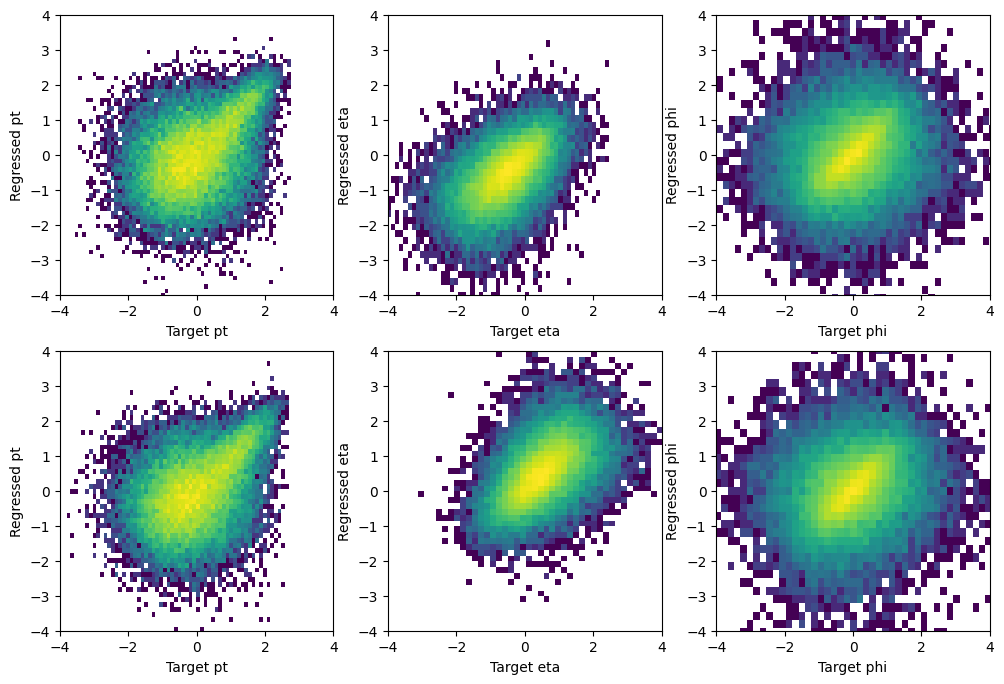

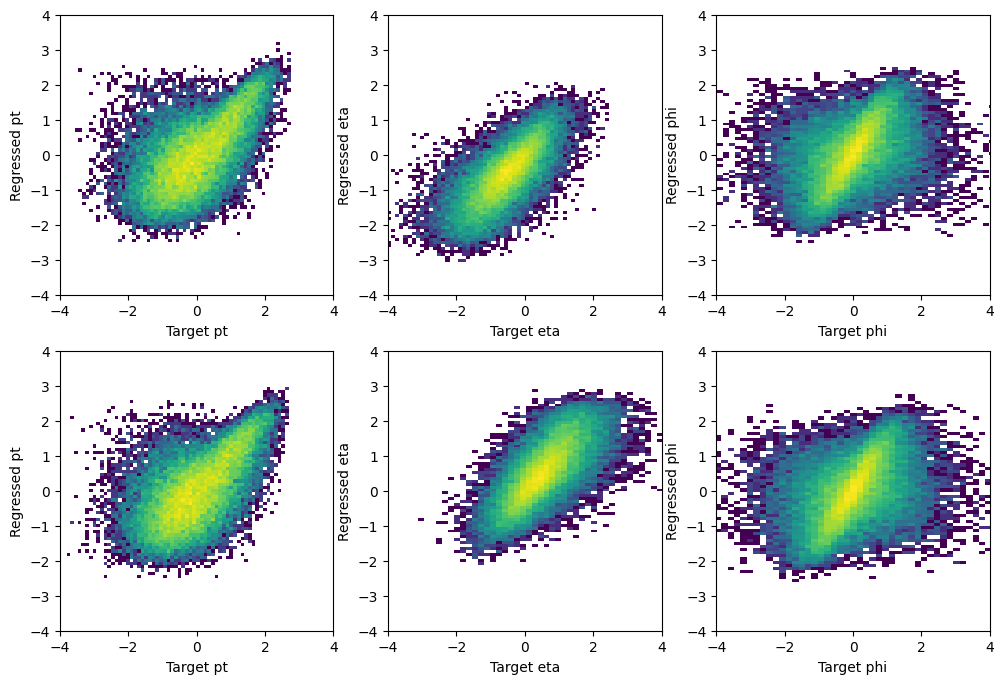

In [24]:
#def validate_flow(model, dataset_val):
Nsamples = 30000
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=Nsamples, device="cuda")

samples_all = torch.zeros(1, Nsamples,  6)
neutrino_m_all = torch.zeros(1, Nsamples,  6)
with torch.no_grad():
    for i in range(Nsamples // 100):
        jets, lepton, met, full_mask, nu, W = dataset_val[i*100:(i+1)*100]
        neutrino_momenta, samples = model(jets,lepton,met, full_mask)
        samples = samples.rsample((1,))
        samples_all[0:, i*100:(i+1)*100] = samples.cpu()
        neutrino_m_all[0:, i*100:(i+1)*100] = neutrino_momenta.cpu()

nu_sampl = torch.reshape(samples_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_sampl_dnn = torch.reshape(neutrino_m_all, (Nsamples, 2, 3)).detach().cpu().numpy()
nu_true = dataset_val[0:Nsamples][4]
plot_samples(nu_sampl, nu_true.cpu().numpy())
plot_samples(nu_sampl_dnn, nu_true.cpu().numpy())